#  Proyecto <a class="tocSkip">


## Importación de Datos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.tree as tree
from sklearn import metrics
import seaborn as sns

df = pd.read_csv("heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:

y = df.DEATH_EVENT
X = df[df.columns[:-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 
obtimes_train = X_train["time"]
obtimes_test = X_test["time"]
X_train = X_train[df.columns[:-2]]
X_test = X_test[df.columns[:-2]]

## Entrenamiento de RandomForest

In [ ]:
# Entrenamiento y generación
clf=RandomForestClassifier(n_estimators=3000,bootstrap = False,
                          min_samples_leaf = 0.04,max_features = 0.5,n_jobs = 2)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [ ]:

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7666666666666667


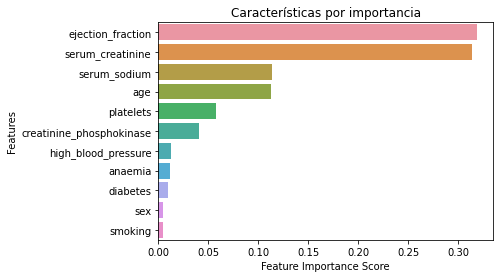

In [ ]:

feature_imp = pd.Series(clf.feature_importances_,index=X.columns[:-1]).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Características por importancia")

RFGraph = plt.show()

## Árboles de Decisión en el RF (DecisionTree)

### Exactitud de los árboles en el bosque

In [ ]:
estimators = clf.estimators_
trees = [e.tree_ for e in estimators]


In [ ]:
def tree_acc(estimator, xe = X_test, ye= y_test):
    y_prede = estimator.predict(xe)
    acc = metrics.accuracy_score(ye, y_prede)
    return acc

def tree_rec(estimator, xe = X_test, ye= y_test):
    y_prede = estimator.predict(xe)
    rec = metrics.recall_score(ye, y_prede)
    return rec

def tree_cf(estimator, xe = X_test, ye= y_test):
    metrics.ConfusionMatrixDisplay.from_estimator(estimator, xe, ye)


Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.

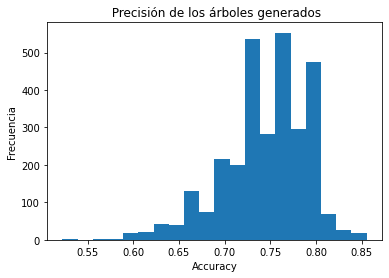

In [ ]:
accs = [tree_acc(e) for e in estimators]
plt.hist(accs,bins =20)
plt.title(" Precisión de los árboles generados")
plt.xlabel("Accuracy")
plt.ylabel("Frecuencia")
plt.show()

### Árbol más exacto

In [ ]:
most_acc = np.argmax(accs)

most_acc = estimators[most_acc]


Mostramos una gŕafica del árbol más preciso generado. En cada nodo se muestra el criterio utilizado en cada paso.

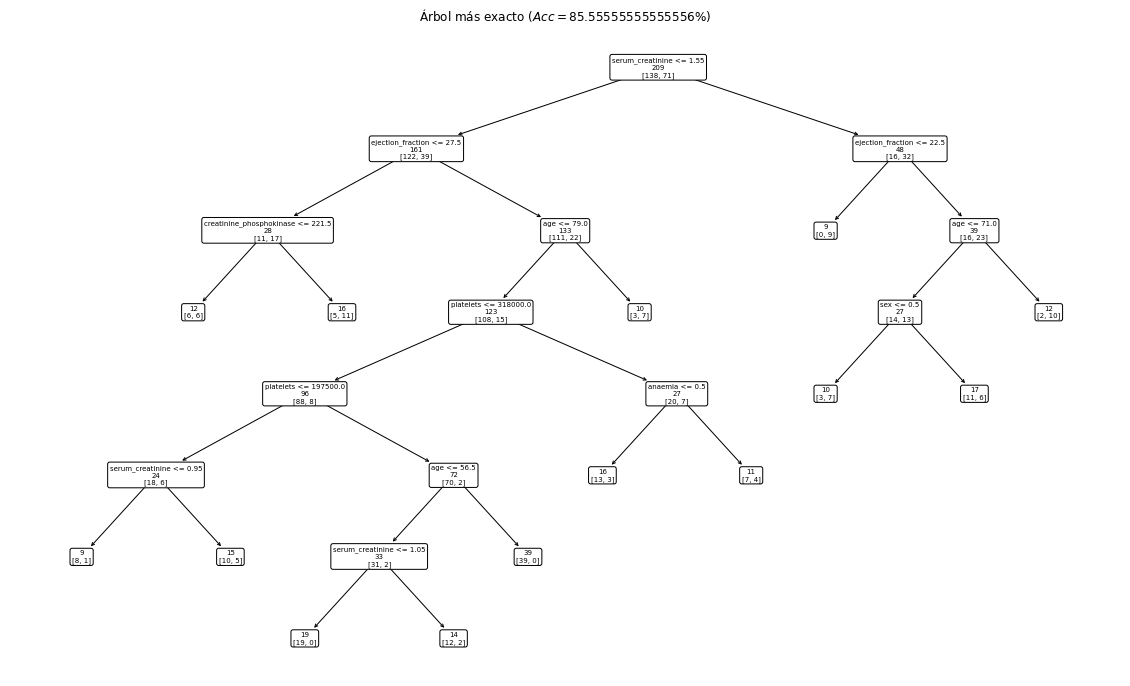

In [ ]:

plt.rcParams['figure.figsize'] = [20, 12]
tree.plot_tree(most_acc,label = 'none',fontsize = 7,rounded = True
               ,impurity = False, feature_names = X_train.columns)
plt.title(f"Árbol más exacto ($Acc = {max(accs)*100}$%)")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


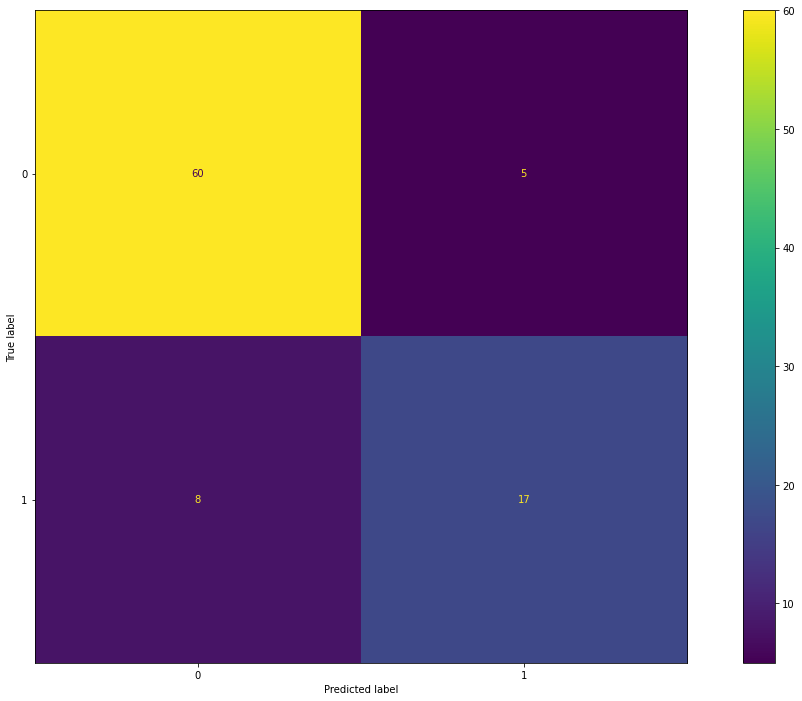

In [ ]:
cm = tree_cf(most_acc)

## Caminos de decisión

Mostramos el camino que se sigue para evaluar una muestra particular.

In [ ]:
xt = np.array(X_train.to_numpy())
feature = most_acc.tree_.feature
threshold = most_acc.tree_.threshold


node_indicator = most_acc.decision_path(xt)
sample_id = 10
leaf_id = most_acc.apply(xt)
# -------------------

# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]
# -------------------

for node_id in node_index:
    # fin de la decisión
    if leaf_id[sample_id] == node_id:
        s = "El paciente probablemente sobreviva" if (most_acc.predict(xt[sample_id:sample_id+1]))[0]==0. else "El paciente probablemente muera"
        print(s)
        continue

    # verificar la rama que sigue
    if xt[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : {feature} = {value} "
        "{inequality} {threshold})".format(
            node=node_id,
            feature=df.columns[feature[node_id]],
            value=xt[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )

decision node 0 : serum_creatinine = 1.0 <= 1.550000011920929)
decision node 1 : ejection_fraction = 25.0 <= 27.5)
decision node 2 : creatinine_phosphokinase = 582.0 > 221.5)
El paciente probablemente muera


## Evaluación de tiempo de decisión

In [ ]:
time_dicc = {"age":0, "anaemia": 24,	"creatinine_phosphokinase":36,	"diabetes":36,	"ejection_fraction":36,	"high_blood_pressure":48,	"platelets":24,	"serum_creatinine":24,	"serum_sodium":24, "sex":0,	"smoking":0,	"time":0,	"DEATH_EVENT":0}

# reemplazar con datos reales
for f in df.columns:
    time_dicc[f]  = time_dicc[f]

def time_required(est,sample ):
    s = []
    features = est.tree_.feature

    node_indicator = est.decision_path(sample)
    for sample_id in range(len(sample)):
        time_req = 0
        features_req = set()
        leaf_id = est.apply(xt)
        # -------------------

        # obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
        node_index = node_indicator.indices[
            node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
        ]
        # -------------------
        
        # Recorre el camino de decisión
        for node_id in node_index:
            # fin de la decisión
            if leaf_id[sample_id] == node_id:
                continue
            
            feature=df.columns[features[node_id]]
            features_req.add(feature)
        # máximo de los tiempos de las caracteristicas usadas
        time_req = max([time_dicc[f] for f in features_req])
        
        s.append(time_req)
    
    return np.array(s)


In [ ]:
def mean_time_required(est,sample):
    return np.mean(time_required(est,sample ))
times = np.array([mean_time_required(e,X_test) for e in estimators])


Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.

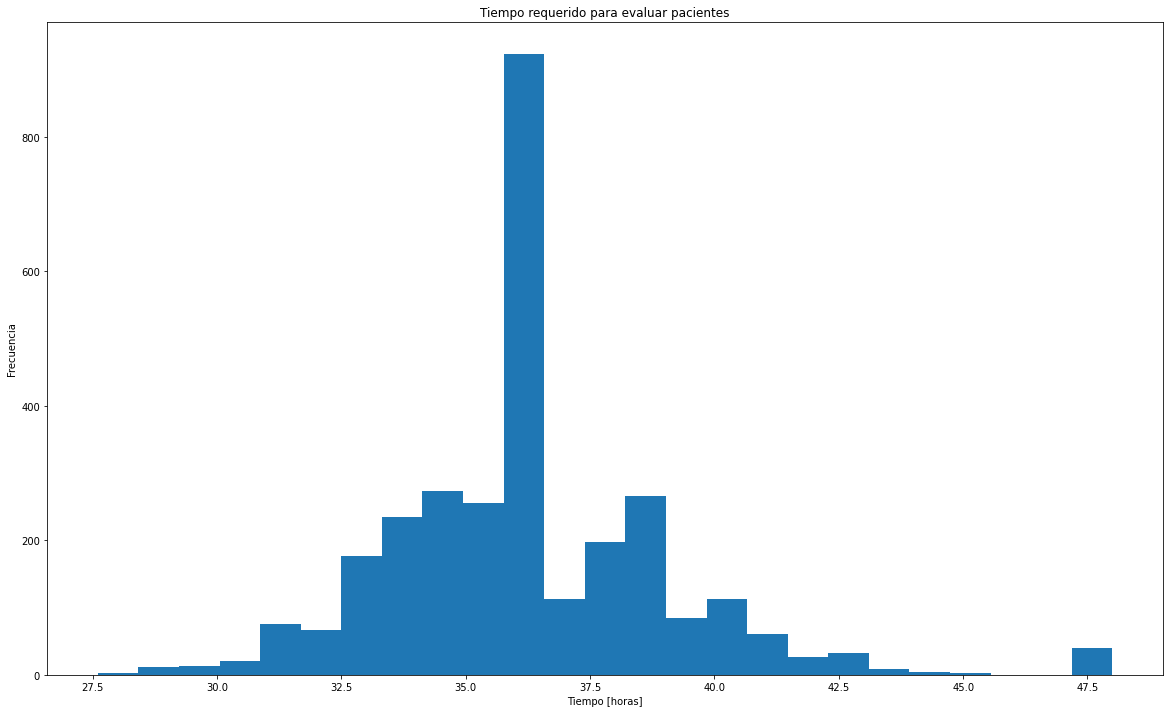

In [ ]:


plt.hist(times,bins = 25)
plt.title("Tiempo requerido para evaluar pacientes")
plt.xlabel("Tiempo [horas]")
plt.ylabel("Frecuencia")
plt.show()

Text(0.5, 1.0, ' Precisión contra tiempo promedio de decisión de los árboles')

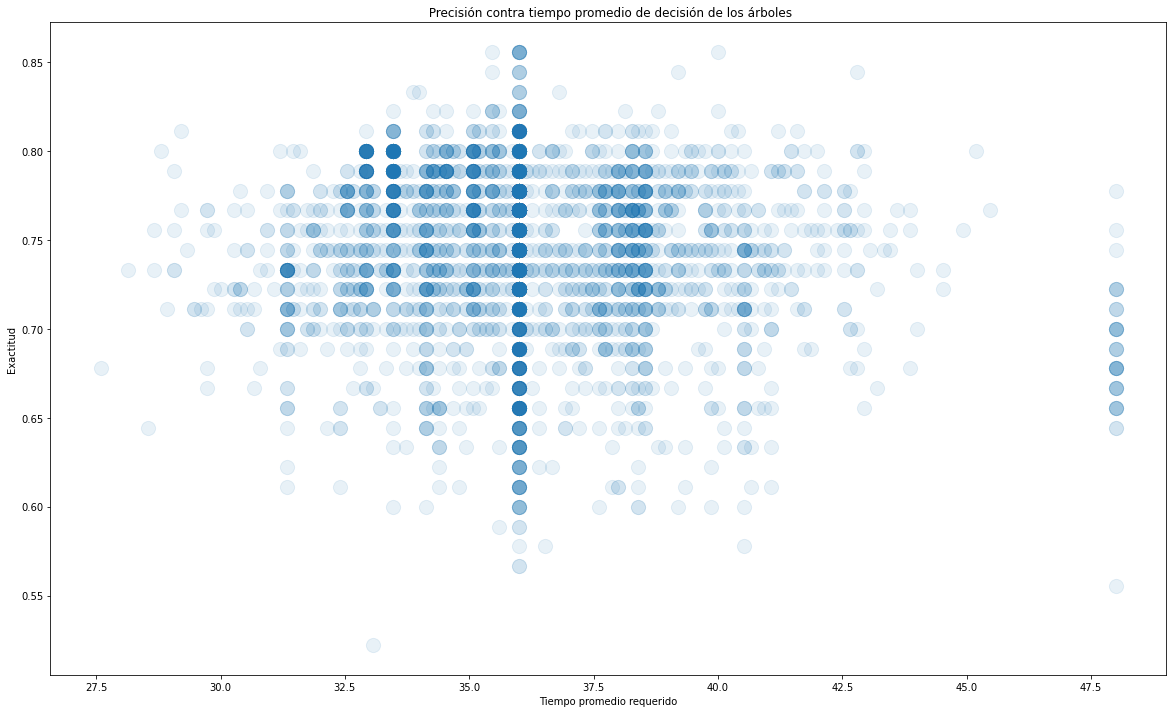

In [ ]:
plt.scatter(times,accs,alpha = 0.1,s = 200)
plt.xlabel("Tiempo promedio requerido")
plt.ylabel("Exactitud")
plt.title(" Precisión contra tiempo promedio de decisión de los árboles")

In [ ]:
np.corrcoef(times,accs)

array([[ 1.        , -0.10774626],
       [-0.10774626,  1.        ]])

## Árbol mas rápido

In [ ]:
fastest = np.argmin(times)

fastest = estimators[fastest]

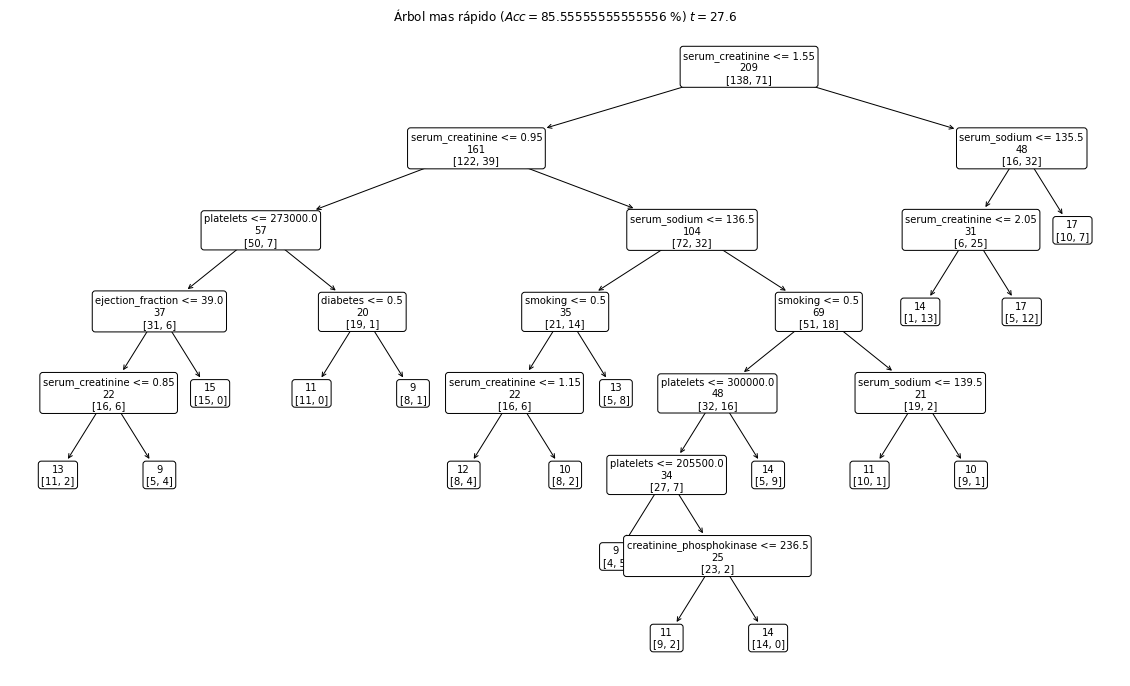

In [ ]:

tree.plot_tree(fastest,label = 'none',fontsize = 10,rounded = True
               ,impurity = False, feature_names = X_train.columns)
plt.title(f"Árbol mas rápido ($Acc = {max(accs)*100}$ %) $t = {min(times)}$")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


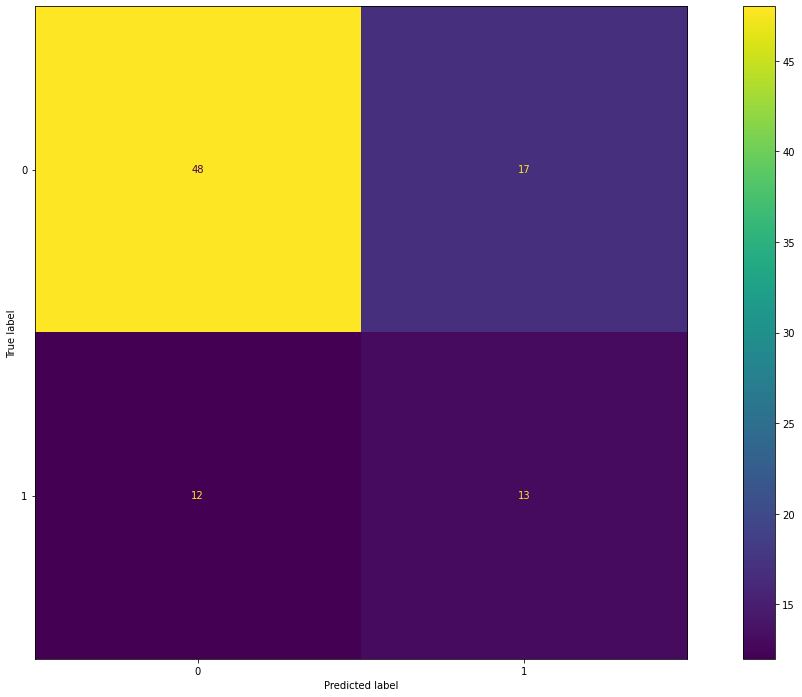

In [ ]:
cm = tree_cf(fastest)

## Árbol más Exhaustivo

In [ ]:
recs = [tree_rec(e) for e in estimators]
most_rec = np.argmax(recs)

most_rec = estimators[most_rec]

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.

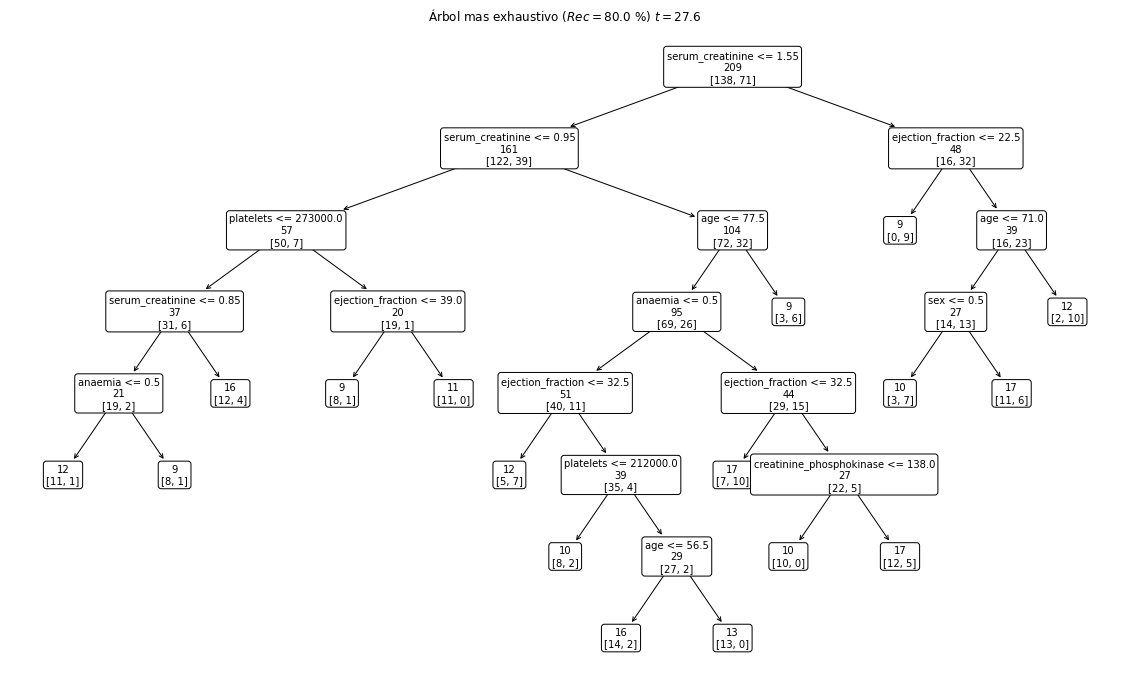

In [ ]:
tree.plot_tree(most_rec,label = 'none',fontsize = 10,rounded = True
               ,impurity = False, feature_names = X_train.columns)
plt.title(f"Árbol mas exhaustivo ($Rec = {max(recs)*100}$ %) $t = {min(times)}$")
plt.show()

Text(0.5, 1.0, 'Exhaustividad contra tiempo promedio de decisión de los árboles')

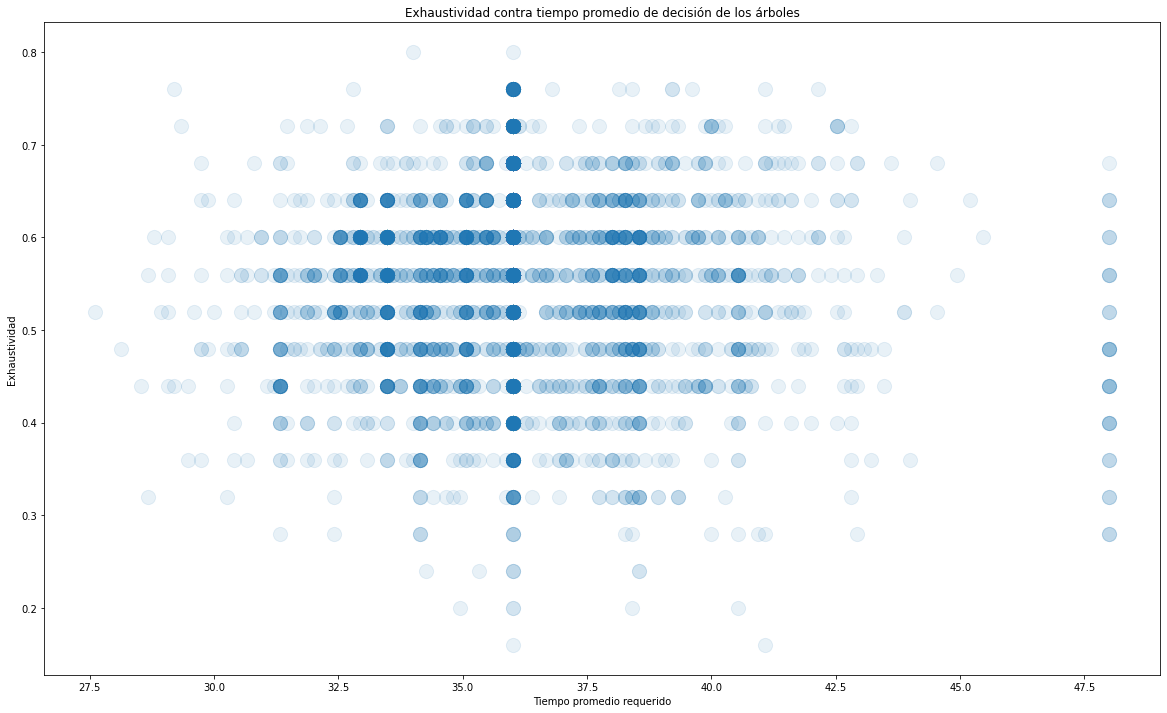

In [ ]:
plt.scatter(times,recs,alpha = 0.1,s = 200)
plt.xlabel("Tiempo promedio requerido")
plt.ylabel("Exhaustividad")
plt.title("Exhaustividad contra tiempo promedio de decisión de los árboles")

In [ ]:
np.corrcoef(times,recs)

array([[ 1.        , -0.02406708],
       [-0.02406708,  1.        ]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


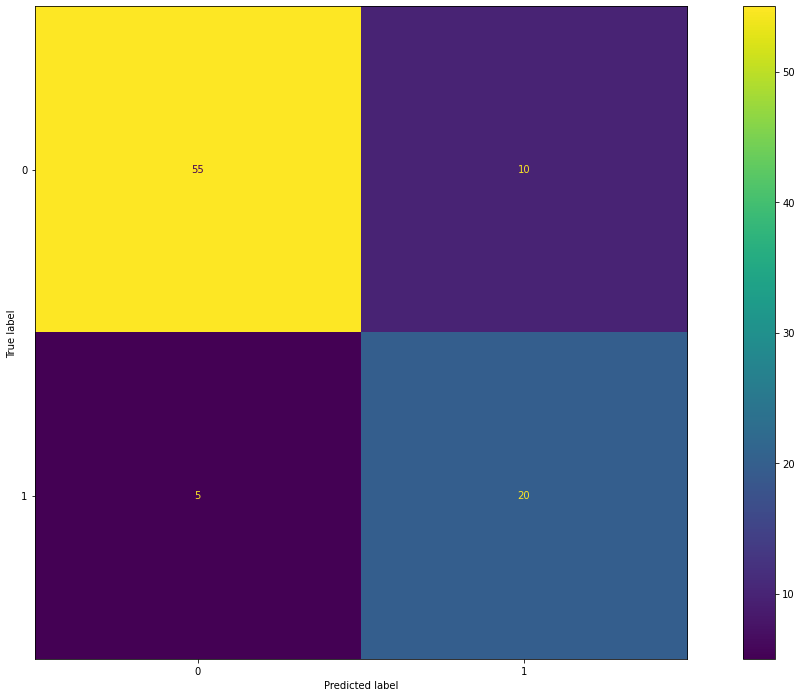

In [ ]:
cm = tree_cf(most_rec)

Text(0.5, 1.0, 'Exhaustividad contra exactitud de los árboles')

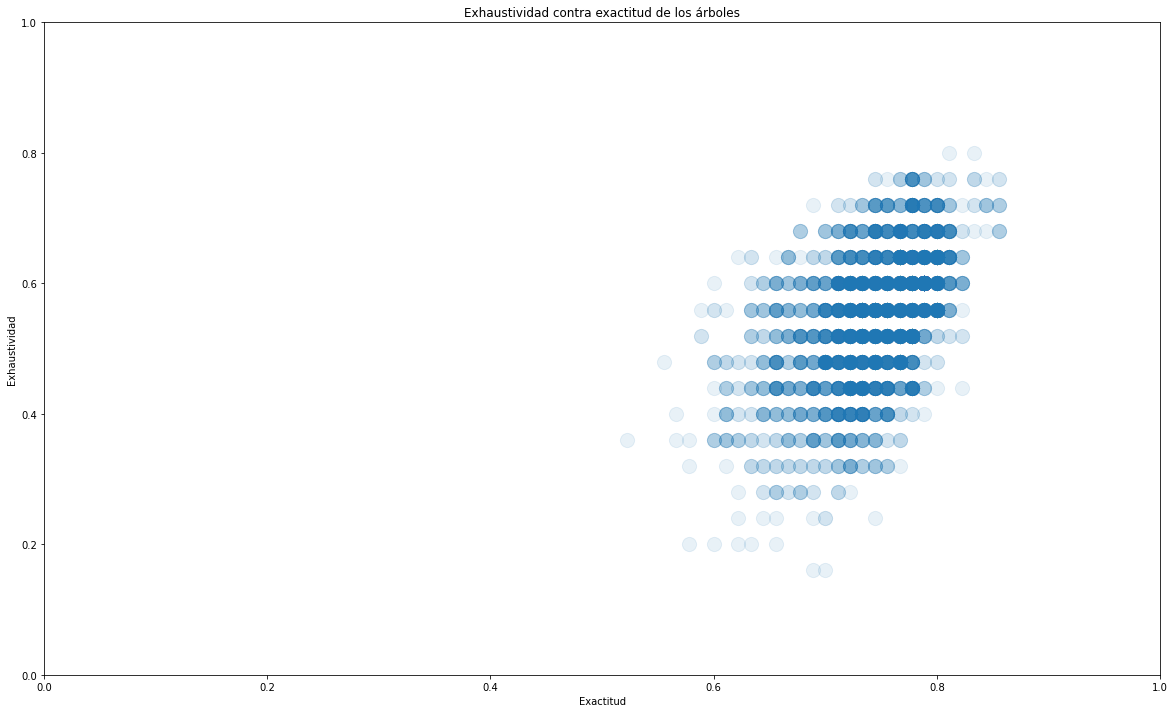

In [ ]:
plt.scatter(accs,recs,alpha = 0.1,s = 200)
plt.xlabel("Exactitud")
plt.ylabel("Exhaustividad")
plt.xlim([0,1])
plt.ylim([0,1])
plt.title("Exhaustividad contra exactitud de los árboles")

## Frácción útil de tiempo

In [ ]:
def tree_utf(estimator, xe = X_test, ye= y_test,ot = obtimes_test):
    deceased = ye == 1
    xs = xe[deceased]
    ys = ye[deceased]
    ot = ot[deceased]
    y_prede = estimator.predict(xs)
    correct = ys == y_prede
    treq = (1-time_required(estimator,xs)/(24*ot))[correct]
    s = np.sum(treq)/len(ys)
    return s
    

In [ ]:
print(f"UTF del árbol mas rápido {tree_utf(fastest)}")
print(f"UTF del árbol mas exacto {tree_utf(most_acc)}")
print(f"UTF del árbol mas exhaustivo {tree_utf(most_rec)}")



UTF del árbol mas rápido 0.5016481543693532
UTF del árbol mas exacto 0.6383957625404654
UTF del árbol mas exhaustivo 0.759923878902947


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has featu

In [ ]:
utfs = [tree_utf(e) for e in estimators]

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.

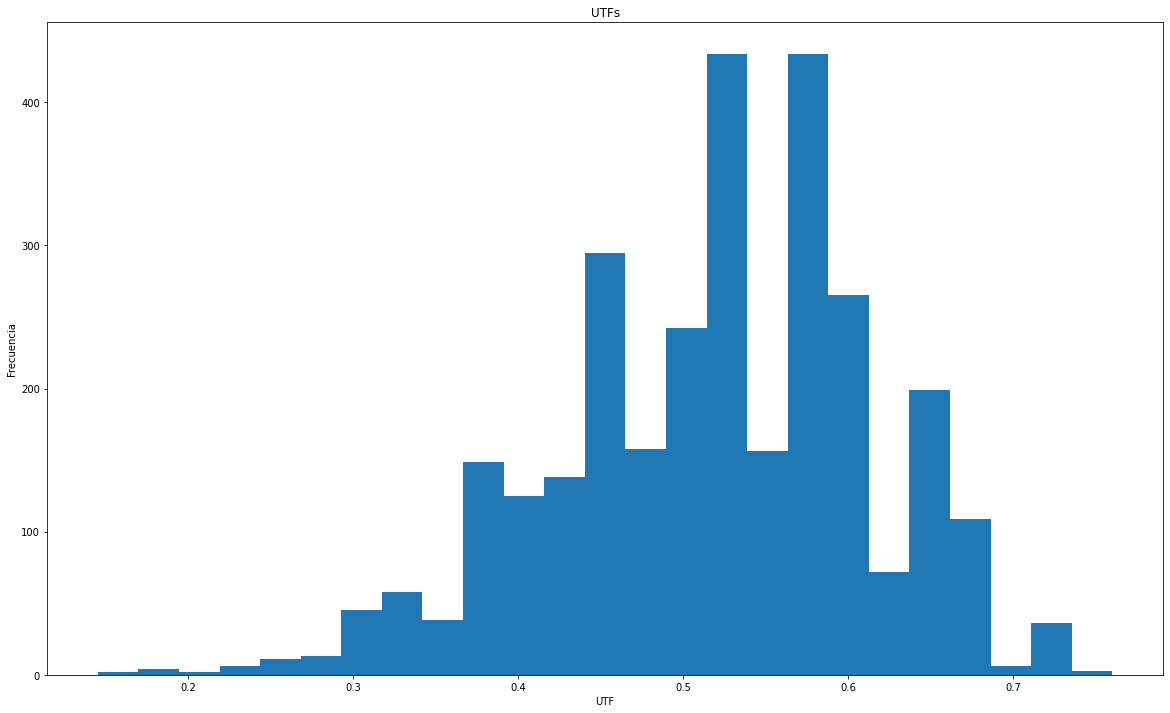

In [ ]:
plt.hist(utfs,bins = 25)
plt.title("UTFs")
plt.xlabel("UTF")
plt.ylabel("Frecuencia")
plt.show()

Text(0.5, 1.0, ' UTF contra tiempo promedio de decisión de los árboles')

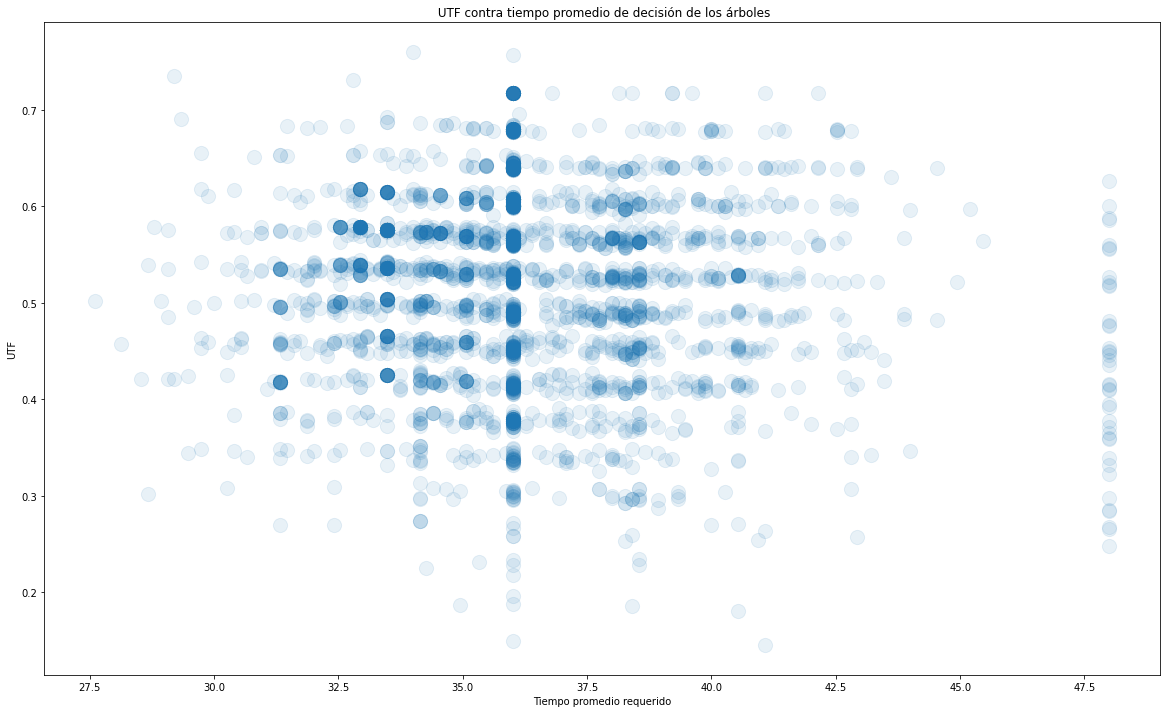

In [ ]:
plt.scatter(times,utfs,alpha = 0.1,s = 200)
plt.xlabel("Tiempo promedio requerido")
plt.ylabel("UTF")
plt.title(" UTF contra tiempo promedio de decisión de los árboles")

In [ ]:
np.corrcoef(times,utfs)

array([[ 1.        , -0.05781708],
       [-0.05781708,  1.        ]])

In [ ]:
np.corrcoef(recs,utfs)

array([[1.        , 0.99800767],
       [0.99800767, 1.        ]])

Text(0.5, 1.0, ' UTF contra exhaustividad de los árboles')

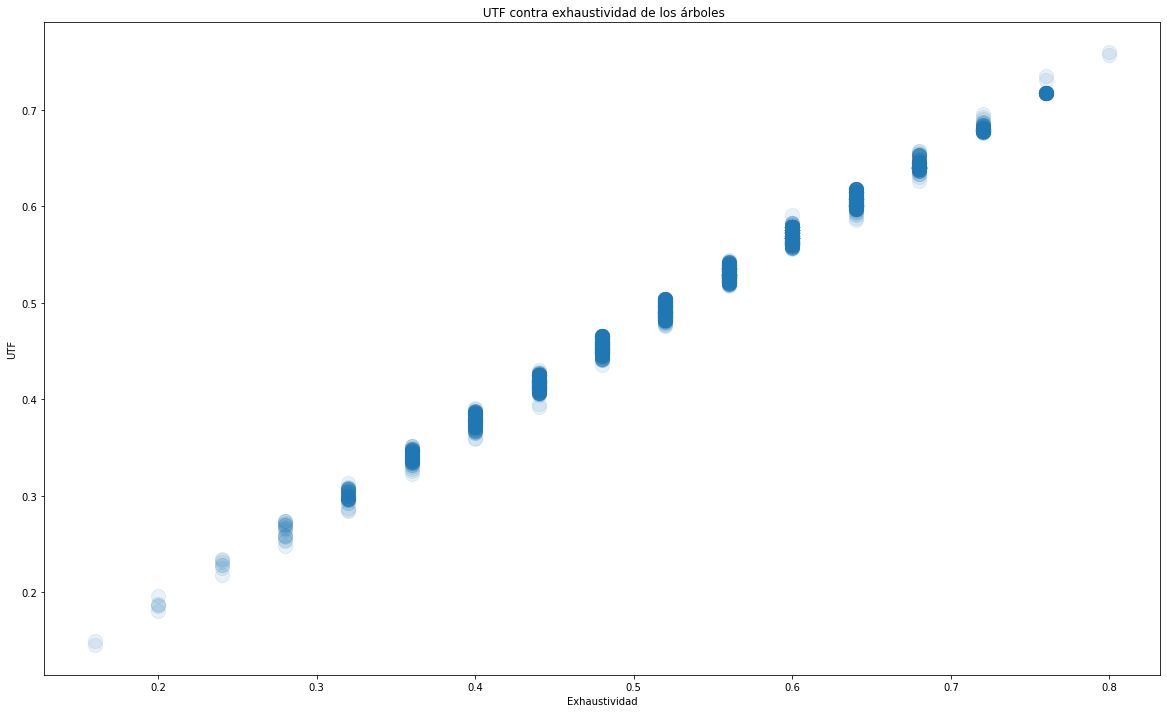

In [ ]:
plt.scatter(recs,utfs,alpha = 0.1,s = 200)
plt.xlabel("Exhaustividad")
plt.ylabel("UTF")
plt.title(" UTF contra exhaustividad de los árboles")

In [ ]:
most_utf = np.argmax(utfs)
most_utf = estimators[most_utf]

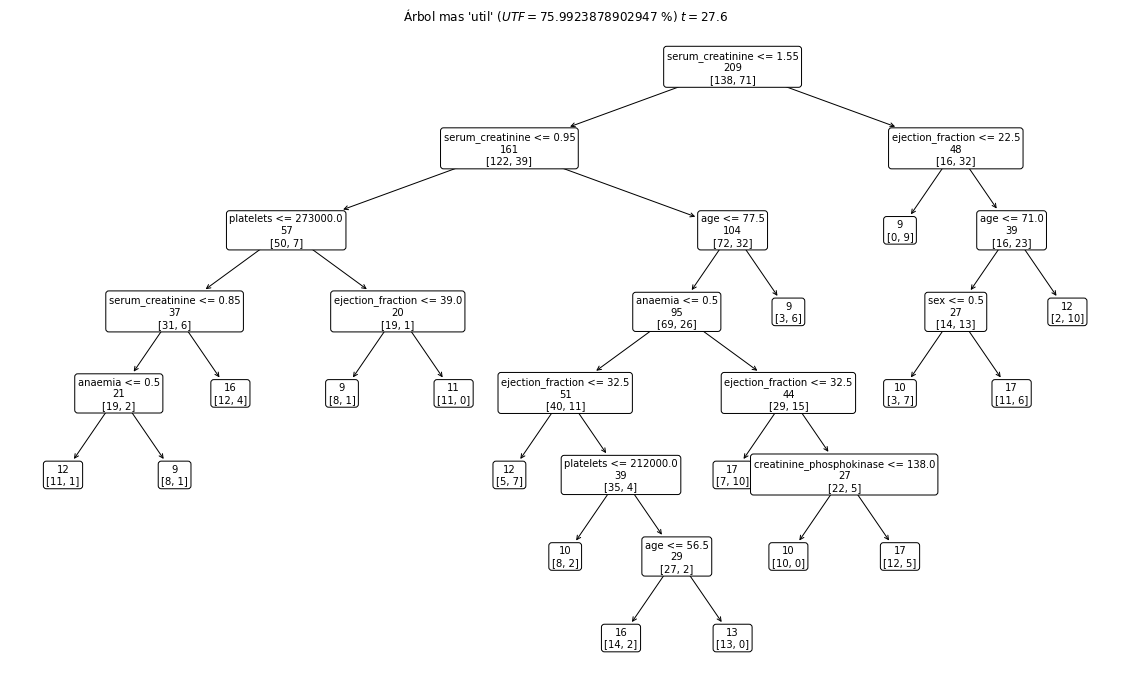

In [ ]:
tree.plot_tree(most_utf,label = 'none',fontsize = 10,rounded = True
               ,impurity = False, feature_names = X_train.columns)
plt.title(f"Árbol mas 'util' ($UTF = {max(utfs)*100}$ %) $t = {min(times)}$")
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


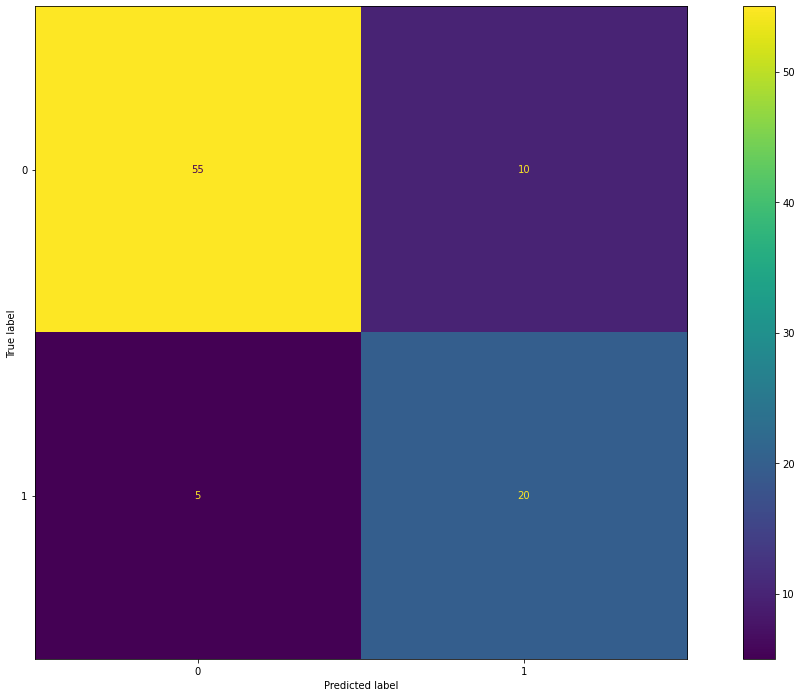

In [ ]:
cm = tree_cf(most_utf)

# Comparación del Modelo Implementado bajo Random Forest vs Modelo bajo PCA

In [ ]:
#Importando algunas librerías
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.base import clone
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
import operator
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
#Importamos los datos
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [ ]:
#Mostramos el head
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:
#Separamos la última columna, correspondiente a si el paciente fallece o no
DeathEvents = df["DEATH_EVENT"]

In [ ]:
#En otro dataframe nos quedamos con el resto de columnas
DF = df.drop(["DEATH_EVENT"],axis=1)

In [ ]:
#Estandarizamos los datos;
DF = StandardScaler().fit_transform(DF[['age',	'anaemia',	'creatinine_phosphokinase',	'diabetes',	'ejection_fraction',	'high_blood_pressure',	'platelets',	'serum_creatinine',	'serum_sodium',	'sex',	'smoking',	'time']])


In [ ]:
#Obtenemos matriz de covarianzas, así como sus eigen valores y vectores
cov_mat= np.cov(np.matrix(DF),rowvar=False)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

In [ ]:
#Formaremos una pequeña lista de listas para almacenar los eigenvalores, 
#eigenvectores y el nombre de los atributos. 
Names = ['age',	'anaemia',	'creatinine_phosphokinase',	'diabetes',	'ejection_fraction',	'high_blood_pressure',	'platelets',	'serum_creatinine',	'serum_sodium',	'sex',	'smoking',	'time']
Importance = []
for i in range(len(eigen_vals)):
  Importance.append([eigen_vals[i],Names[i],eigen_vecs[i]])

#Además, los mostraremos en orden de mayor a menor valor de los eigen valores
Order = []
while Importance:
  maximo = max(Importance)
  Order.append(maximo)
  Importance.pop(Importance.index(maximo))

In [ ]:
Order

[[1.6685462480947244,
  'age',
  array([ 0.04910096,  0.49093212,  0.12151432, -0.18210792, -0.16446757,
         -0.20240001, -0.65509629, -0.06267437,  0.19751419, -0.16599892,
         -0.35633781, -0.11835126])],
 [1.58439449743191,
  'anaemia',
  array([-0.22818273,  0.3204641 ,  0.06436889, -0.15043645, -0.44657937,
          0.01811168,  0.12014194,  0.41444309, -0.209261  ,  0.08088611,
          0.05271662,  0.6159471 ])],
 [1.2723980577627887,
  'diabetes',
  array([-0.2846968 , -0.1515776 ,  0.03243156,  0.38923962,  0.01187394,
         -0.32934027,  0.1766399 , -0.15138995, -0.28035104, -0.16550095,
         -0.67561158,  0.13508449])],
 [1.1196829490710638,
  'serum_creatinine',
  array([ 0.0371995 ,  0.4036002 ,  0.01876487,  0.26900254,  0.08717814,
         -0.46910716,  0.38606819, -0.04707428,  0.4028128 , -0.34200535,
          0.31904772,  0.05536368])],
 [1.0333391681431967,
  'serum_sodium',
  array([-9.35383046e-02, -2.40870937e-01,  6.15979019e-04, -6.25528185e

<BarContainer object of 12 artists>

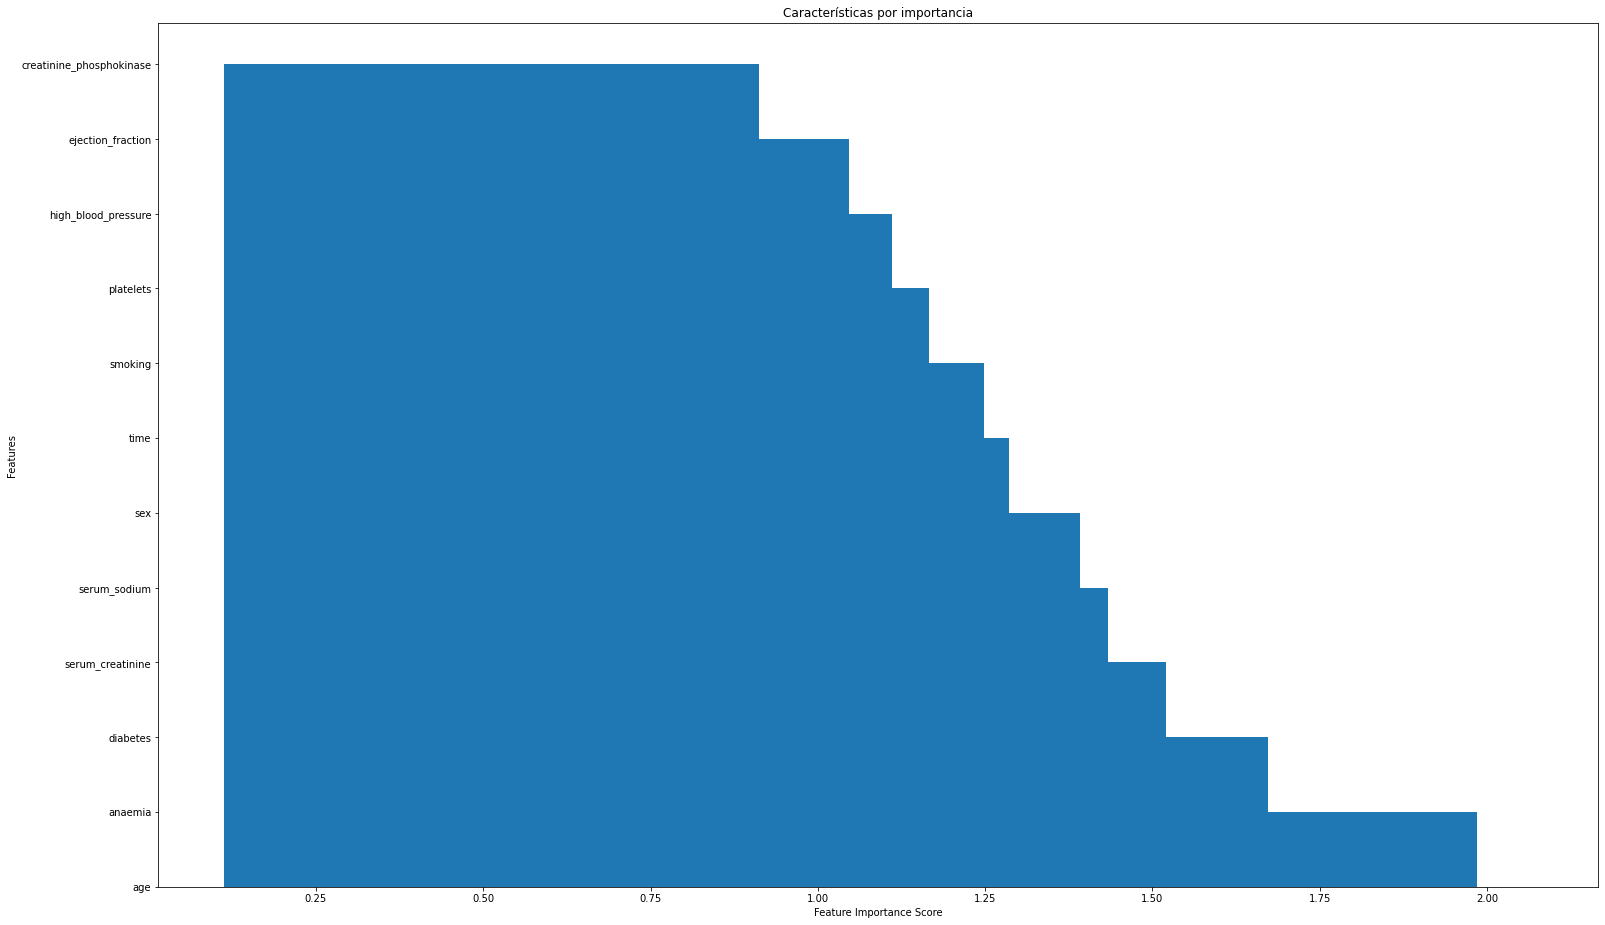

In [ ]:
#Crearemos algunas listas para mostrar una gráfica de barras 
#Con los resultados obtenidos del punto anterior
x = []
y = []
for i in range(len(Order)):
  x.append(Order[i][0])
  y.append( Order[i][1])

#Gráfica de barras
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Características por importancia")
ax.bar(x, y)

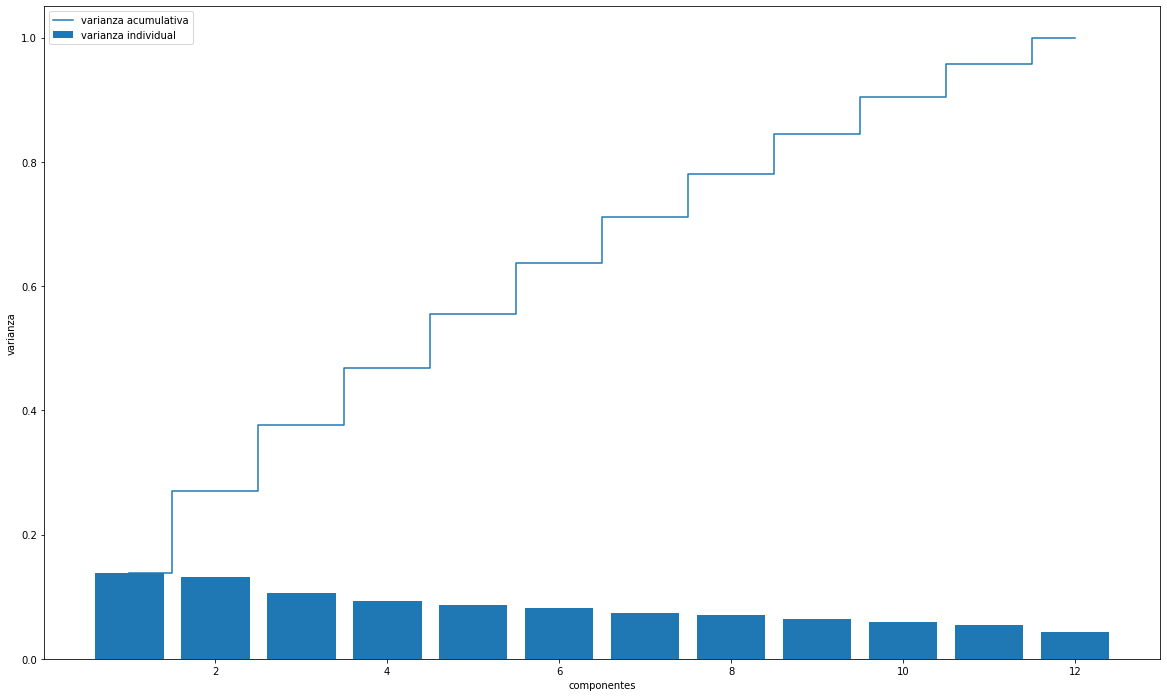

In [ ]:
#Mostraremos una gráfica de la varianza individual y de la acumulativa
tot = sum(eigen_vals) 
var_exp = [ev/tot for ev in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp) #suma acumulativa 
plt.bar(range(1,13), var_exp, label='varianza individual', align='center')
plt.step(range(1,13),cum_var_exp,where='mid', label='varianza acumulativa')
plt.xlabel('componentes')
plt.ylabel('varianza')
plt.legend(loc='best')
plt.show()

In [ ]:
#Observaremos las varianzas acumulativas 
suma=0
vect=[]
total = 0
for i in range(12):
  total += Order[i][0]

for i in range(12):
    suma+=Order[i][0]
    vect.append(100*(suma/total))
print(vect)

[13.85804854883579, 27.017177875332703, 37.58503242419868, 46.8845173412326, 55.46687721042638, 63.707509002577645, 71.06882591484988, 78.11289834507613, 84.47971275088064, 90.37813757774002, 95.74490100695866, 100.0]


In [ ]:
#Dado el resultado anterior, emplearemos las primeras 9 PCA, es decir, nos
#restringiremos al 84.5%
#Creamos una lista con los eigenvectores de las primeras 9 PCA
CP = []
for i in range(9):
  CP.append(Order[i][2])
CP

[array([ 0.04910096,  0.49093212,  0.12151432, -0.18210792, -0.16446757,
        -0.20240001, -0.65509629, -0.06267437,  0.19751419, -0.16599892,
        -0.35633781, -0.11835126]),
 array([-0.22818273,  0.3204641 ,  0.06436889, -0.15043645, -0.44657937,
         0.01811168,  0.12014194,  0.41444309, -0.209261  ,  0.08088611,
         0.05271662,  0.6159471 ]),
 array([-0.2846968 , -0.1515776 ,  0.03243156,  0.38923962,  0.01187394,
        -0.32934027,  0.1766399 , -0.15138995, -0.28035104, -0.16550095,
        -0.67561158,  0.13508449]),
 array([ 0.0371995 ,  0.4036002 ,  0.01876487,  0.26900254,  0.08717814,
        -0.46910716,  0.38606819, -0.04707428,  0.4028128 , -0.34200535,
         0.31904772,  0.05536368]),
 array([-9.35383046e-02, -2.40870937e-01,  6.15979019e-04, -6.25528185e-01,
         3.83207487e-01, -5.41120917e-01,  1.82632057e-02,  1.82981635e-02,
         1.02885510e-01,  1.92637591e-01, -3.98504714e-02,  2.28768365e-01]),
 array([ 0.62237639,  0.03396914, -0.69090

In [ ]:
#Para proyectar los resultados anteriores, convertiremos el dataframe
#sin los registros de eventos a un array de numpy
M = np.array(DF)
np.shape(M)

(299, 12)

In [ ]:
#Multiplicamos ambas matrices
x1=M@np.transpose(CP)
x1
np.shape(x1)

(299, 9)

In [ ]:
#Aplicamos K medias para 2 clusters
km= KMeans(n_clusters=2)
km = km.fit(x1)
y_hat = km.predict(x1) 

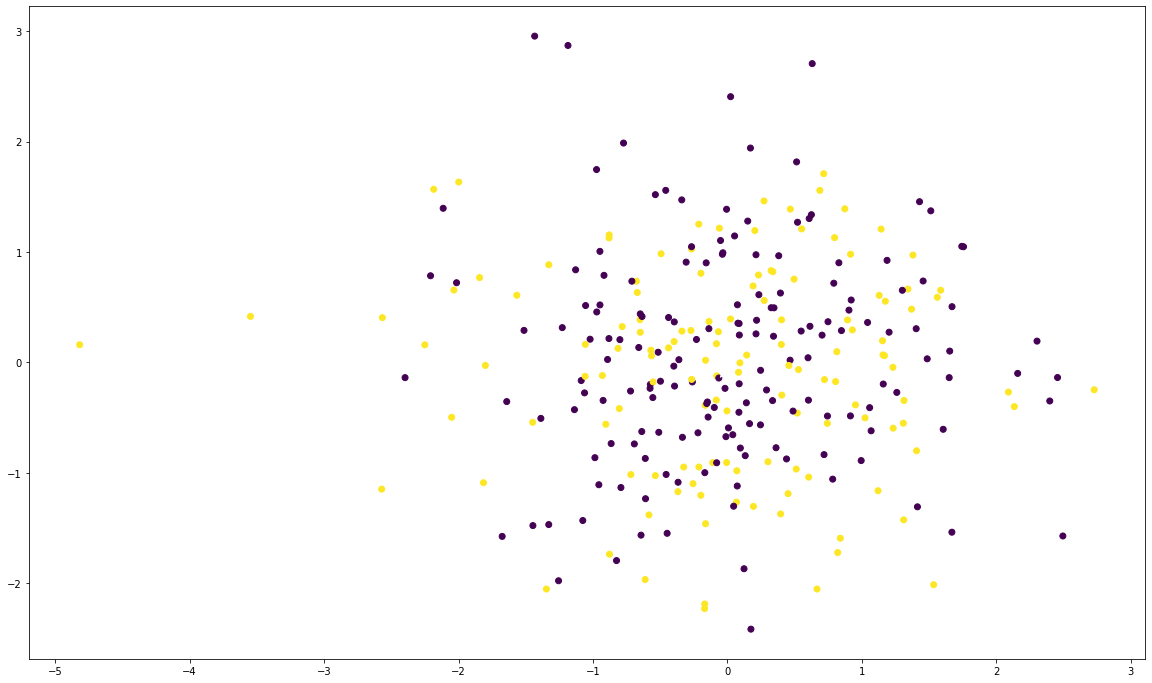

In [ ]:
#Graficamos los clusters en 2D
C= km.cluster_centers_
fig,ax = plt.subplots()
ax.scatter(x1[:,0],x1[:,1], c= y_hat) 
ax.scatter(C[:,0], C[:,1], marker='*', s=200,c='w')

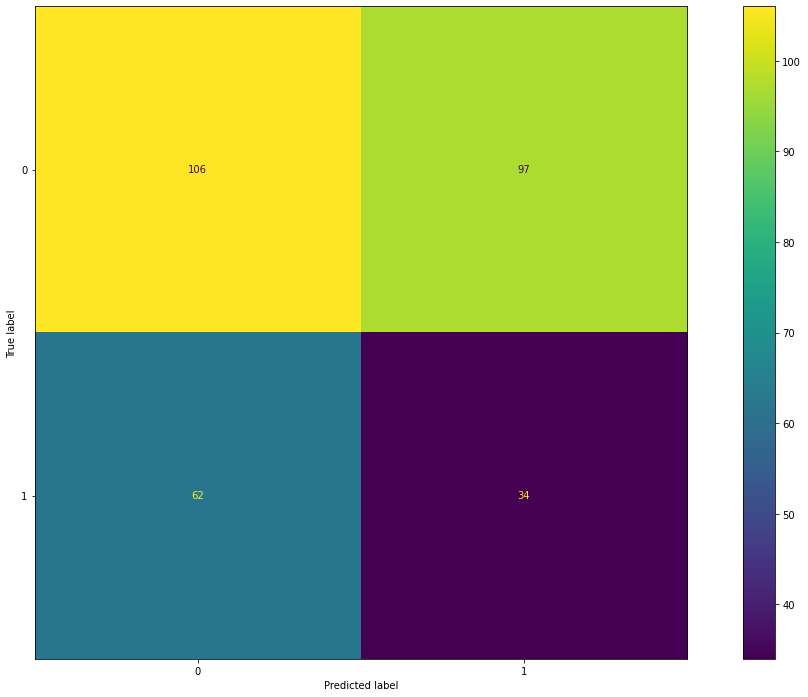

In [ ]:
#Sacamos la matriz de confusión
ConfusionMatrix = confusion_matrix(DeathEvents, y_hat)
ConfusionMatrixDisplay(ConfusionMatrix).plot()

## Comparación entre el Modelo PCA y el Modelo Random Forest

Para la comparación entre ambos modelos, debemos recordar que;

* El Modelo PCA se realizó con las primeras 9 componentes principales. 

* El Modelo Random Forest se ejecutó con $3000$ árboles. 

* La comparación será sobre el árbol más preciso, y no sobre el más rápido o el más exhaustivo.

De las gráficas de características por importancia se observó que en ambos Modelos las características no son valuadas con la misma importancia; mientras para el Modelo de Random Forest las primeras 5 componentes son; 

* Creatinina en suero.

* Fracción de eyección. 

* Edad. 

* Creatinina fosfoquinasa. 

* Plaquetas. 

Para el modelo de PCA son; 

* Edad.

* Anemia.

* Diabetes.

* Creatinina en suero. 

* Sodio en suero

Difiriendo prácticamente en su totalidad. 

Por otro lado, notamos que la matriz de confusión del Modelo de PCA obtiene una traza de esta es de 150 (de 299 registros), mientras que en Modelo de Random Forest es de apenas 69 (de 90). Sin embargo, esto se traduce en un accuracy del 0.50 para el Modelo de PCA y del 0.76 para el Random Forest. 

De esto, podemos concluir que el árbol más preciso es mejor que el Modelo de PCA, al menos para las primeras 9 componentes. 

El resultado anterior refleja la cercanía que tiene un Random Forest y un árbol de decisión al proceso de diagnóstico médico de un profesional de la salud. 

Concluimos además que, al menos al nivel presentado, el Modelo de Random Forest muestra ser más rico en información, dado que se nos proporciona la toma de decisiones paso a paso. Sin embargo, no se concluye que el modelo de PCA pueda ser mejorado variando el número de componentes empleadas o las componentes empleadas en sí. 